In [1]:
import pandas as pd
import settings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # ignore warning for odd numpy/statsmodels VisibleDeprecationWarning in KDE plot

Import the cleaned training dataset

In [2]:
train_df = pd.read_csv('%s/train.csv' % settings.PROCESSED_DIR, header=0)
train_df = train_df[~train_df['foreclosure_status'].isnull()]

Create categorical groupby DataFrame for categorical bar plotting

In [6]:
cat_vars = ['channel','loan_purpose','first_time_homebuyer', 'borrower_count', 'occupancy_status']
groupby_frames = {}

for v in cat_vars:
    # Calculate the total count of each foreclosure_status & categorical variable combination
    groupby_frames[v] = train_df.groupby(['foreclosure_status',v])[v].count()

    # Calculate percentage share of foreclosure_status-level percentage of each facet of the categorical variable
    groupby_frames[v] =  groupby_frames[v].groupby(level=0).apply(lambda x: x/float(x.sum()))
    groupby_frames[v] = pd.DataFrame(groupby_frames[v])
    groupby_frames[v].columns = ['share']

    # Flatten groupby frame to prepare for bar plot
    groupby_frames[v] = groupby_frames[v].reset_index()

Produce KDE pair plots for the continuous variables, and bar plots for the categorical variables

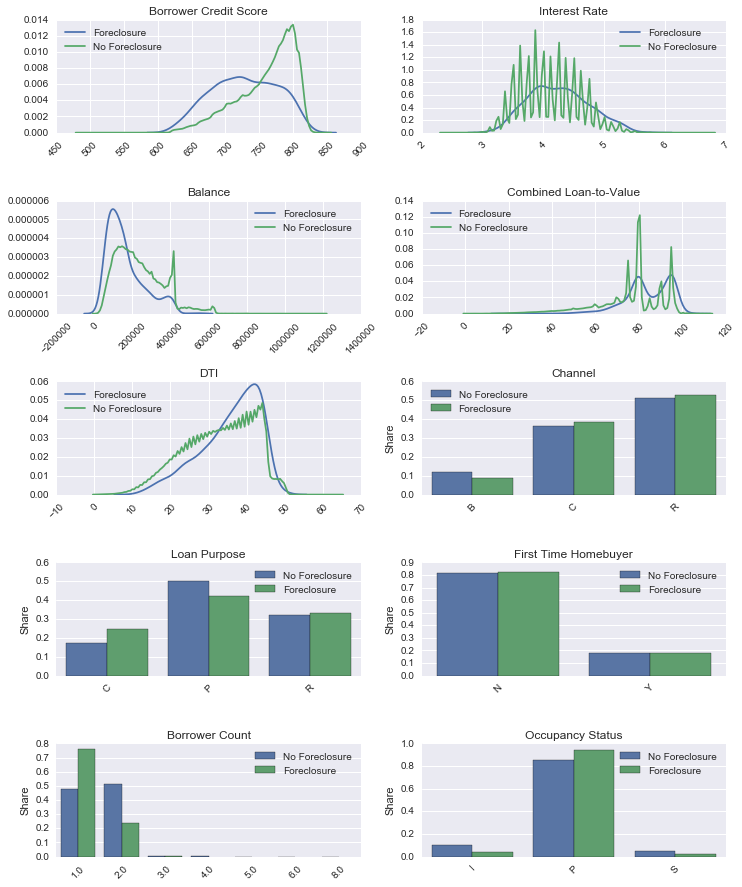

In [16]:
def kde_pair_subplot(ax, var_name, title):
    for tf in [True, False]:
        data = train_df.ix[train_df['foreclosure_status'] == tf, var_name]
        data = data[~data.isnull()]
        sns.kdeplot(data, legend=False, ax=ax)
    sns.plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    labels = ['Foreclosure', 'No Foreclosure']
    if (ax == ax1) or (ax == ax4) or (ax == ax5):
        ax.legend(handles, labels, loc='upper left')
    else:
        ax.legend(handles, labels)
        
def share_bar_subplot(ax, var_name, title):
    data = groupby_frames[var_name]
    sns.barplot(x=var_name, y='share', hue='foreclosure_status', data=data, ax=ax)
    sns.plt.setp(ax.get_xticklabels(), rotation=45, )

    # Set title and ylabel
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Share')

    # Set legends for each plot
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[:2]
    labels = ['No Foreclosure','Foreclosure']
    if ax == ax6: # the legend in the first bar plot will overlap with the bars if it's left in the upper right
        ax.legend(handles, labels, loc='upper left')
    else:
        ax.legend(handles, labels)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = sns.plt.subplots(5,2)
kde_axs = [ax1, ax2, ax3, ax4, ax5]
kde_vars = ['borrower_credit_score', 'interest_rate', 'balance', 'cltv', 'dti']
kde_titles = ['Borrower Credit Score', 'Interest Rate', 'Balance', 'Combined Loan-to-Value', 'DTI']

cat_axs = [ax6, ax7, ax8, ax9, ax10]
cat_vars = ['channel','loan_purpose','first_time_homebuyer', 'borrower_count', 'occupancy_status']
cat_titles = ['Channel', 'Loan Purpose', 'First Time Homebuyer', 'Borrower Count', 'Occupancy Status']

for ax,var,title in zip(kde_axs, kde_vars, kde_titles):
    kde_pair_subplot(ax, var, title)

for ax,var,title in zip(cat_axs, cat_vars, cat_titles):
    share_bar_subplot(ax,var,title)
    
f.subplots_adjust(hspace=0.6, wspace=0.2)
f.set_size_inches(12, 15)
sns.plt.show()

Let's get an initial peek at what matters in determining the foreclosure rate. We'll use the Logit model from statsmodels to get z statistics & p values for each predictor coefficient.

In [17]:
import statsmodels.api as sm

# Specify labels and features to use for classification models
label = 'foreclosure_status_True'
features = ['score_div_cltv','borrower_credit_score','cltv','interest_rate', 'dti', 'balance_log', 'first_time_homebuyer_Y',
            'channel_C','channel_R', 'loan_purpose_C','loan_purpose_P', 'single_borrower_Y', 'occupancy_status_I',
            'occupancy_status_P']

# Fit the Logit model
logit = sm.Logit(train_df[label], sm.add_constant(train_df[features]))
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.002762
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                             
===================================================================================
Dep. Variable:     foreclosure_status_True   No. Observations:              4199190
Model:                               Logit   Df Residuals:                  4199175
Method:                                MLE   Df Model:                           14
Date:                     Thu, 11 Aug 2016   Pseudo R-squ.:                  0.1047
Time:                             20:37:29   Log-Likelihood:                -11597.
converged:                            True   LL-Null:                       -12952.
                                             LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                      8.7723      0.867     10.114      0.000         7.072    10.472
score_div_cltv             0.0134      0.015      0.879      0.380        -0.017     0.043
borrower_credit_score     -0.0108      0.001    -16.823      0.000        -0.012    -0.010
cltv                       0.0805      0.004     21.206      0.000         0.073     0.088
interest_rate             -0.1962      0.058     -3.368      0.001        -0.310    -0.082
dti                        0.0310      0.003      8.933      0.000         0.024     0.038
balance_log               -1.3225      0.049    -26.719      0.000        -1.420    -1.226
first_time_homebuyer_Y    -0.5242      0.085     -6.164      0.000        -0.691    -0.357
channel_C                  0.0839      0.099      0.845      0.398        -0.111     0.278
channel_R                  0.0062      0.097      0.064      0.949        -0.184     0.196
loan_purpose_C             0.2905      0.076      3.802      0.000         0.141     0.440
loan_purpose_P            -1.0580      0.075    -14.186      0.000        -1.204    -0.912
single_borrower_Y          0.7966      0.063     12.568      0.000         0.672     0.921
occupancy_status_I        -0.4444      0.220     -2.021      0.043        -0.875    -0.013
occupancy_status_P         0.3985      0.174      2.288      0.022         0.057     0.740
==========================================================================================

Possibly complete quasi-separation: A fraction 0.44 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Most of the predictors are statistically significant, as expected. I was surprised the score_div_cltv predictor wasn't significant, since that one was suggested in the Fannie Mae data tutorials on http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html.

Next we'll use scikit-learn's LogisticRegression model and cross_val_predict function to train & cross-validate a Logistic Regression model. Then we'll calcualte some binary classification performance metrics.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_predict

# Create a LogRet model, then cross validate the model on the training dataset using cross_val_predict
logistic_model = LogisticRegression(class_weight='balanced')
logistic_predictions = cross_val_predict(logistic_model, train_df[features], train_df[label], cv=4)

# Evaluate logistic regression model with accuracy score, a confusion matrix, and a classification report
print('Logistic Regression Accuracy Score: %s' %metrics.accuracy_score(train_df[label], logistic_predictions))

print('Logistic Regression Confusion Matrix:')
print(metrics.confusion_matrix(train_df[label], logistic_predictions))

print('Logistic Regression Classification Report:')
print(metrics.classification_report(logistic_predictions, train_df[label]))

Logistic Regression Accuracy Score: 0.752699687321
Logistic Regression Confusion Matrix:
[[3159565 1038182]
 [    279    1164]]
Logistic Regression Classification Report:
             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86   3159844
        1.0       0.81      0.00      0.00   1039346

avg / total       0.77      0.75      0.65   4199190



Now let's see if a Random Forest Classifier gives us more accurate predictions

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(max_depth=10, n_estimators=40, class_weight='balanced')
forest_predictions = cross_val_predict(forest_model, train_df[features], train_df[label], cv=4)

# Evaluate logistic regression model with accuracy score, a confusion matrix, and a classification report
print('Random Forest Accuracy Score: %s' %metrics.accuracy_score(train_df[label], forest_predictions))

print('Random Forest Confusion Matrix:')
print(metrics.confusion_matrix(train_df[label], forest_predictions))

print('Random Forest Classification Report:')
print(metrics.classification_report(forest_predictions, train_df[label]))

Random Forest Accuracy Score: 0.875484319595
Random Forest Confusion Matrix:
[[3675530  522217]
 [    648     795]]
Random Forest Classification Report:
             precision    recall  f1-score   support

        0.0       0.88      1.00      0.93   3676178
        1.0       0.55      0.00      0.00    523012

avg / total       0.84      0.88      0.82   4199190

